# DATASET 1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, GRU, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2025-03-01 22:48:52.495553: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 22:48:52.499864: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-01 22:48:52.513492: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740849532.538540 1367598 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740849532.545922 1367598 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-01 22:48:52.571604: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/saama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/saama/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Download 'punkt_tab' to a specific directory
nltk.download('punkt_tab', download_dir='./nltk_data')

# Add the directory to NLTK's data path
nltk.data.path.append('./nltk_data')

# Check if the resource is now available
try:
    nltk.data.find('tokenizers/punkt_tab')
    print("Resource 'punkt_tab' found successfully!")
except LookupError:
    print("Resource 'punkt_tab' still not found.")

Resource 'punkt_tab' found successfully!


[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
# Function for text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Apply lemmatization
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

In [ ]:
# Load dataset from Excel file
df = pd.read_excel("dataset1.xlsx")  # Ensure this file is in the correct directory

In [ ]:
# Combine title and abstract into a single text feature
df["text"] = (df["TITLE"] + " " + df["ABSTRACT"]).apply(preprocess_text)

In [ ]:
# Define topic labels
topic_columns = ["Computer Science", "Physics", "Mathematics", "Statistics", "Quantitative Biology", "Quantitative Finance"]
# Calculate the sum of each topic column (number of documents belonging to each topic)
topic_counts = df[topic_columns].sum()

# Calculate the total number of documents in the DataFrame
total_documents = len(df)

# Calculate the percentage of documents belonging to each topic
topic_percentages = (topic_counts / total_documents) * 100

# Print the percentage distribution for each topic
print("Percentage Distribution of Topics:")
for topic, percentage in topic_percentages.items():
    print(f"{topic}: {percentage:.2f}%")


# Calculate the sum of labels of all the columns
number_of_labels = 0
for i in topic_columns:
  number_of_labels += np.sum(df[i])




Percentage Distribution of Topics:
Computer Science: 40.98%
Physics: 28.67%
Mathematics: 26.79%
Statistics: 24.82%
Quantitative Biology: 2.80%
Quantitative Finance: 1.19%


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_train_val_test(df, train_size=0.5, val_size=0.2, test_size=0.3, random_state=42):
    """Splits a Pandas DataFrame into training, validation, and test sets."""



    train_df, temp_df = train_test_split(df, test_size=(1 - train_size), random_state=random_state)  # Split train from val+test

    val_size_rel = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(temp_df, test_size=(1 - val_size_rel), random_state=random_state)  # Split val from test

    return train_df, val_df, test_df




train_df, val_df, test_df = split_train_val_test(df, train_size=0.5, val_size=0.2, test_size=0.3)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 10486
Validation set size: 4194
Test set size: 6292


In [ ]:
X_train = train_df['text'].tolist()
X_val = val_df['text'].tolist()
X_test = test_df['text'].tolist()

In [ ]:
y_train = train_df[topic_columns].values
y_val = val_df[topic_columns].values
y_test = test_df[topic_columns].values


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf
from tensorflow.keras import backend as K

# 1. Calculate TF-IDF Features
max_words = 10000 # Define max_words
def calculate_tfidf(X_train, X_val, X_test, max_words=10000): # pass max_words argument
    """
    Calculates TF-IDF vectors for training, validation, and test sets.

    Args:
        X_train (list): Training text data.
        X_val (list): Validation text data.
        X_test (list): Test text data.
        max_words (int): Maximum number of features (words) to consider.

    Returns:
        X_train_tfidf (numpy.ndarray): TF-IDF vectors for the training set.
        X_val_tfidf (numpy.ndarray): TF-IDF vectors for the validation set.
        X_test_tfidf (numpy.ndarray): TF-IDF vectors for the test set.
    """
    vectorizer = TfidfVectorizer(max_features=max_words)
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray() # Fit on training data
    X_val_tfidf = vectorizer.transform(X_val).toarray()       # Transform validation data
    X_test_tfidf = vectorizer.transform(X_test).toarray()      # Transform test data
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer # Also return the vectorizer to transform test/validation data



X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer = calculate_tfidf(X_train, X_val, X_test, max_words) # Apply to your data

In [ ]:
# 2. Reshape Input
# The reshape depends on how you want to feed the TF-IDF vectors into the RNN.
# Option 1: Treat each TF-IDF vector as a single time step.
#     In this case, the RNN effectively acts as a dense layer.
time_steps = 1  # Each TF-IDF vector is one time step
features = X_train_tfidf.shape[1]  # Number of TF-IDF features

X_train_tfidf = X_train_tfidf.reshape((X_train_tfidf.shape[0], time_steps, features))
X_val_tfidf = X_val_tfidf.reshape((X_val_tfidf.shape[0], time_steps, features))
X_test_tfidf = X_test_tfidf.reshape((X_test_tfidf.shape[0], time_steps, features))


In [ ]:
num_classes = y_train.shape[1]

In [ ]:
history_results = {}
conf_matrices = {}

In [ ]:
features

10000

## MODELS

In [ ]:
def create_rnn_model(features, num_classes):
    """
    Creates an RNN model using TF-IDF features as input.

    Args:
        features (int): Number of TF-IDF features.
        num_classes (int): Number of classes in the classification problem.

    Returns:
        model (tensorflow.keras.models.Sequential): The compiled RNN model.
    """
    model = Sequential([
        SimpleRNN(128, input_shape=(1, features), return_sequences=True, recurrent_dropout=0.2),  # input_shape must match TF-IDF shape
        SimpleRNN(128, recurrent_dropout=0.2),
        BatchNormalization(),  # Helps stabilize learning
        Dense(128),
        LeakyReLU(alpha=0.1),  # More stable than ReLU
        Dropout(0.4),  # Prevents overfitting
        Dense(num_classes, activation='sigmoid')
    ])
    return model

# Get num_classes


#Create the model
model_1 = create_rnn_model(features, num_classes)



def create_birnn_model(features, num_classes):
    """
    Creates a BiRNN model using TF-IDF features as input.

    Args:
        features (int): Number of TF-IDF features.
        num_classes (int): Number of classes in the classification problem.

    Returns:
        model (tensorflow.keras.models.Sequential): The compiled BiRNN model.
    """
    model = Sequential([
        Bidirectional(SimpleRNN(256, input_shape=(time_steps, features), return_sequences=True, recurrent_dropout=0.2)),  # BiRNN with SimpleRNN
        Dropout(0.3),
        Bidirectional(SimpleRNN(256, recurrent_dropout=0.2)),  # Another BiRNN layer
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='sigmoid')
    ])
    return model


model_2 = create_birnn_model(features, num_classes)


# 3. Modify the Model

def create_lstm_model(features, num_classes):
    """
    Creates an RNN model using TF-IDF features as input.

    Args:
        features (int): Number of TF-IDF features.
        num_classes (int): Number of classes in the classification problem.

    Returns:
        model (tensorflow.keras.models.Sequential): The compiled RNN model.
    """
    model = Sequential([
        LSTM(128, input_shape=(1, features), return_sequences=True, recurrent_dropout=0.2),  # LSTM with input shape matching TF-IDF
        LSTM(128, recurrent_dropout=0.2),  # Stacked LSTM
        BatchNormalization(),  # Stabilizes training
        Dense(128),
        LeakyReLU(alpha=0.1),  # LeakyReLU for better gradient flow
        Dropout(0.4),  # Reduces overfitting
        Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label classification
    ])
    return model


num_classes = y_train.shape[1]
#Create the model
model_3 = create_lstm_model(features, num_classes) # Pass features and num_classes


def create_BILSTM_model(features, num_classes):
    """
    Creates a BiRNN model using TF-IDF features as input.

    Args:
        features (int): Number of TF-IDF features.
        num_classes (int): Number of classes in the classification problem.

    Returns:
        model (tensorflow.keras.models.Sequential): The compiled BiRNN model.
    """
    model = Sequential([
        Bidirectional(LSTM(128, return_sequences=True, recurrent_dropout=0.2), input_shape=(1, features)),  # Bidirectional LSTM
        Bidirectional(LSTM(128, recurrent_dropout=0.2)),  # Second BiLSTM layer
        BatchNormalization(),  # Helps stabilize learning
        Dense(128),
        LeakyReLU(alpha=0.1),  # More stable than ReLU
        Dropout(0.4),  # Prevents overfitting
        Dense(num_classes, activation='sigmoid')  # Sigmoid for multi-label classification
    ])
    return model

model_4 = create_BILSTM_model(features, num_classes)

W0000 00:00:1740849632.762690 1367598 gpu_device.cc:2344] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/saama/anaconda3/envs/nlp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/saama/anaconda3/envs/nlp/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/home/saama/anaconda3/envs/nlp/lib/python3.11/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass 

# RNN


In [ ]:
from tensorflow.keras.losses import binary_crossentropy
optimizer = AdamW(learning_rate=0.001)

# model_1.compile(optimizer=optimizer, loss=focal_loss(alpha=0.25, gamma=2.0), metrics=["accuracy"])
model_1.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=["accuracy"])

class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

# Get the number of training examples AFTER TF-IDF and reshaping
num_train_examples = X_train_tfidf.shape[0]
# Adjust y_train to match the number of training examples
y_train_subset = y_train[:num_train_examples]


history_results['RNN'] = model_1.fit(X_train_tfidf, y_train_subset, epochs=20, batch_size=128, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4502 - loss: 0.4538 - val_accuracy: 0.6834 - val_loss: 0.5100
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7477 - loss: 0.1270 - val_accuracy: 0.7206 - val_loss: 0.3876
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8106 - loss: 0.0712 - val_accuracy: 0.7458 - val_loss: 0.3110
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8415 - loss: 0.0512 - val_accuracy: 0.7728 - val_loss: 0.2442
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8518 - loss: 0.0400 - val_accuracy: 0.7785 - val_loss: 0.2421
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8832 - loss: 0.0272 - val_accuracy: 0.7451 - val_loss: 0.2696
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8737 - loss: 0.0216 - val_accuracy: 0.7425 - val_loss: 0.3343
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8776 - loss: 0.0167 - val_accuracy: 0.7287 - v

197/197 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step    
Accuracy: 0.7723


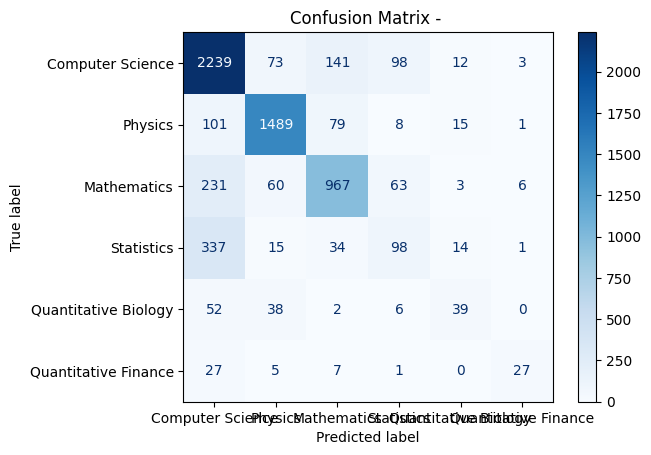

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
y_pred_1 = model_1.predict(X_test_tfidf).argmax(axis=1)
y_true_1 = y_test.argmax(axis=1)
cm_1 = confusion_matrix(y_true_1, y_pred_1)
#conf_matrices[name] = cm_1
accuracy = accuracy_score(y_true_1, y_pred_1)
print(f"Accuracy: {accuracy:.4f}")
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=topic_columns)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - ")
plt.show()
history_results['RNN'].history['test_accuracy']=accuracy

# BIRNN

In [ ]:

# 5. Compile and Train
optimizer = AdamW(learning_rate=0.0001)
model_2.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=["accuracy"])


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Get the number of training examples AFTER TF-IDF and reshaping
num_train_examples = X_train_tfidf.shape[0]
# Adjust y_train to match the number of training examples
y_train_subset = y_train[:num_train_examples]


history_results['BIRNN'] = model_2.fit(X_train_tfidf, y_train_subset, epochs=20, batch_size=128, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 58ms/step - accuracy: 0.1993 - loss: 0.6528 - val_accuracy: 0.3753 - val_loss: 0.5161
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.2412 - loss: 0.4771 - val_accuracy: 0.4723 - val_loss: 0.4476
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4055 - loss: 0.4459 - val_accuracy: 0.4981 - val_loss: 0.3691
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5109 - loss: 0.3732 - val_accuracy: 0.5057 - val_loss: 0.3244
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - accuracy: 0.5524 - loss: 0.2974 - val_accuracy: 0.5162 - val_loss: 0.2950
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.5740 - loss: 0.2419 - val_accuracy: 0.5637 - val_loss: 0.2692
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6271 - loss: 0.2060 - val_accuracy: 0.6423 - val_loss: 0.2448
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.6686 - loss: 0.1768 - val_accuracy: 0.6686 - 

197/197 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step   
Accuracy: 0.7134


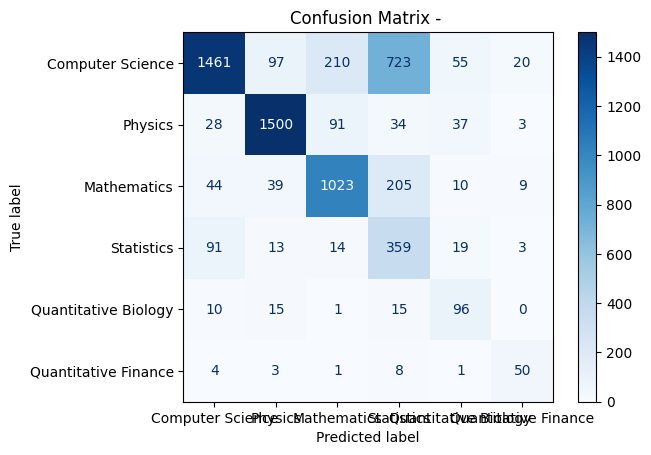

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
y_pred_2 = model_2.predict(X_test_tfidf).argmax(axis=1)
y_true_2 = y_test.argmax(axis=1)
cm_2 = confusion_matrix(y_true_2, y_pred_2)
#conf_matrices[name] = cm_1
accuracy = accuracy_score(y_true_2, y_pred_2)
print(f"Accuracy: {accuracy:.4f}")
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=topic_columns)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - ")
plt.show()
history_results['BIRNN'].history['test_accuracy']=accuracy

# LSTM

In [ ]:

# 5. Compile and Train
optimizer = AdamW(learning_rate=0.0001)
model_3.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=["accuracy"])


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Get the number of training examples AFTER TF-IDF and reshaping
num_train_examples = X_train_tfidf.shape[0]
# Adjust y_train to match the number of training examples
y_train_subset = y_train[:num_train_examples]


history_results['LSTM'] = model_3.fit(X_train_tfidf, y_train_subset, epochs=20, batch_size=128, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 16s 78ms/step - accuracy: 0.3857 - loss: 0.6926 - val_accuracy: 0.2580 - val_loss: 0.6716
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 57ms/step - accuracy: 0.6342 - loss: 0.6269 - val_accuracy: 0.4449 - val_loss: 0.6232
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6502 - loss: 0.5370 - val_accuracy: 0.2358 - val_loss: 0.5664
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.5709 - loss: 0.3824 - val_accuracy: 0.3753 - val_loss: 0.5067
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - accuracy: 0.5508 - loss: 0.2767 - val_accuracy: 0.4514 - val_loss: 0.4358
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6001 - loss: 0.2211 - val_accuracy: 0.5150 - val_loss: 0.3591
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step - accuracy: 0.6513 - loss: 0.1769 - val_accuracy: 0.6316 - val_loss: 0.2952
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.7021 - loss: 0.1451 - val_accuracy: 0.6927 - 

197/197 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step
Accuracy: 0.7230


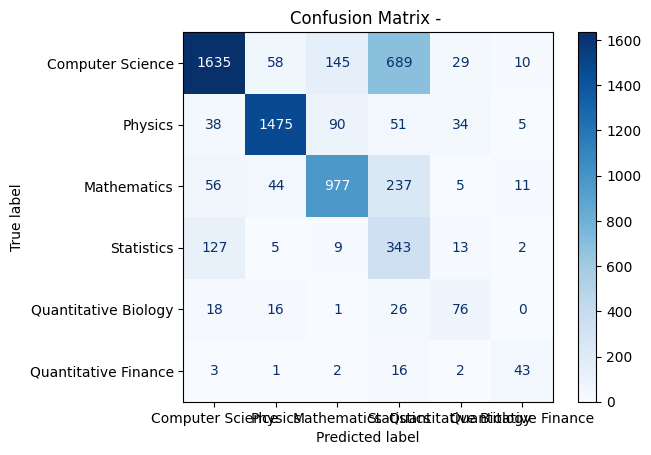

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
y_pred_3 = model_3.predict(X_test_tfidf).argmax(axis=1)
y_true_3 = y_test.argmax(axis=1)
cm_3 = confusion_matrix(y_true_3, y_pred_3)
#conf_matrices[name] = cm_1
accuracy = accuracy_score(y_true_3, y_pred_3)
print(f"Accuracy: {accuracy:.4f}")
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=topic_columns)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - ")
plt.show()
history_results['LSTM'].history['test_accuracy']=accuracy

# BILSTM

In [ ]:

# 5. Compile and Train
optimizer = AdamW(learning_rate=0.0001)
model_4.compile(optimizer=optimizer, loss=binary_crossentropy, metrics=["accuracy"])


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Get the number of training examples AFTER TF-IDF and reshaping
num_train_examples = X_train_tfidf.shape[0]
# Adjust y_train to match the number of training examples
y_train_subset = y_train[:num_train_examples]


history_results['BILSTM']= model_4.fit(X_train_tfidf, y_train_subset, epochs=20, batch_size=128, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.3766 - loss: 0.6837 - val_accuracy: 0.2470 - val_loss: 0.6597
Epoch 2/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 127ms/step - accuracy: 0.6385 - loss: 0.5880 - val_accuracy: 0.6929 - val_loss: 0.5944
Epoch 3/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.6313 - loss: 0.4159 - val_accuracy: 0.5835 - val_loss: 0.5277
Epoch 4/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.6172 - loss: 0.2701 - val_accuracy: 0.6905 - val_loss: 0.4559
Epoch 5/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 140ms/step - accuracy: 0.6537 - loss: 0.1935 - val_accuracy: 0.7501 - val_loss: 0.3821
Epoch 6/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 137ms/step - accuracy: 0.6959 - loss: 0.1534 - val_accuracy: 0.7730 - val_loss: 0.3103
Epoch 7/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 129ms/step - accuracy: 0.7306 - loss: 0.1269 - val_accuracy: 0.7778 - val_loss: 0.2543
Epoch 8/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 128ms/step - accuracy: 0.7725 - loss: 0.1057 - val_accu

197/197 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step
Accuracy: 0.7599


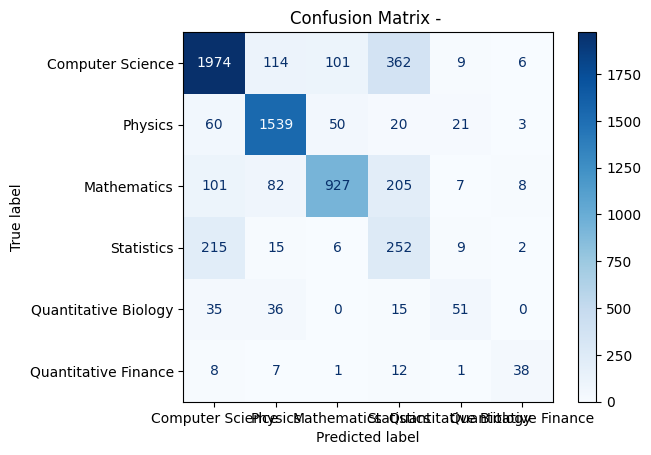

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
y_pred_4 = model_4.predict(X_test_tfidf).argmax(axis=1)
y_true_4 = y_test.argmax(axis=1)
cm_4 = confusion_matrix(y_true_4, y_pred_4)
#conf_matrices[name] = cm_1
accuracy = accuracy_score(y_true_4, y_pred_4)
print(f"Accuracy: {accuracy:.4f}")
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=topic_columns)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - ")
plt.show()
history_results['BILSTM'].history['test_accuracy']=accuracy

# COMPARISON

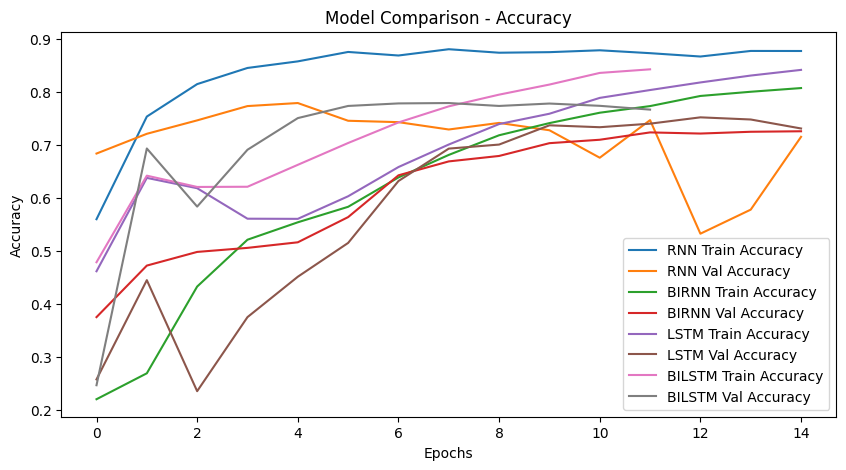

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
for name, history in history_results.items():
    plt.plot(history.history['accuracy'], label=f"{name} Train Accuracy")
    plt.plot(history.history['val_accuracy'], label=f"{name} Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Comparison - Accuracy")
plt.legend()
plt.show()


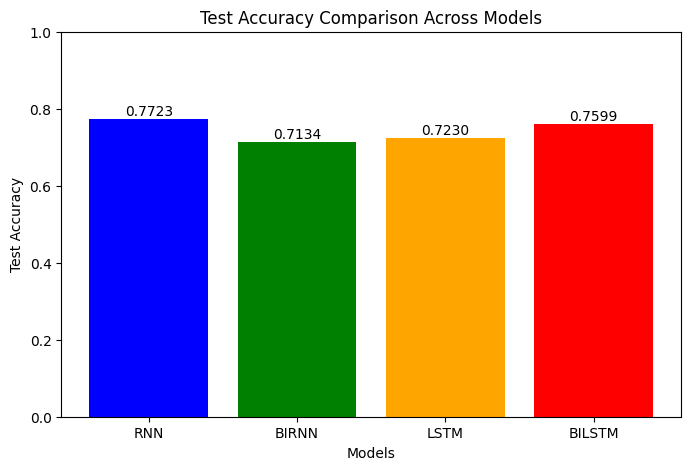

In [ ]:
# Extract test accuracies from history_results
test_accuracies = {
    name: history.history.get('test_accuracy', None)  # Use `.history` attribute
    for name, history in history_results.items()
    if 'test_accuracy' in history.history
}

# Plot test accuracies
plt.figure(figsize=(8, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Models")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison Across Models")
plt.ylim(0, 1)  # Test accuracy values are between 0 and 1
for i, v in enumerate(test_accuracies.values()):
    if v is not None:  # Avoid errors if test_accuracy is None
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')  # Display accuracy values above bars
plt.show()


# DATASET 2

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.tokenize import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, GRU, Conv1D, MaxPooling1D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/saama/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/saama/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Download 'punkt_tab' to a specific directory
nltk.download('punkt_tab', download_dir='./nltk_data')

# Add the directory to NLTK's data path
nltk.data.path.append('./nltk_data')

# Check if the resource is now available
try:
    nltk.data.find('tokenizers/punkt_tab')
    print("Resource 'punkt_tab' found successfully!")
except LookupError:
    print("Resource 'punkt_tab' still not found.")

Resource 'punkt_tab' found successfully!


[nltk_data] Downloading package punkt_tab to ./nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Initialize lemmatizer and stemmer
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer()

In [ ]:
# Function for text preprocessing
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(f"[{string.punctuation}]", "", text)  # Remove punctuation
    text = re.sub(r"\d+", "", text)  # Remove numbers
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    tokens = word_tokenize(text)  # Tokenize text
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Apply lemmatization
    tokens = [stemmer.stem(word) for word in tokens]
    return " ".join(tokens)

In [ ]:
# Load dataset from Excel file
df = pd.read_excel("dataset2.xlsx")  # Ensure this file is in the correct directory

In [ ]:
# Combine title and abstract into a single text feature
df["text"] = (df["Content"]).apply(preprocess_text)

In [ ]:
domain_columns = df['Domain'].unique().tolist()

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

def split_train_val_test(df, train_size=0.5, val_size=0.2, test_size=0.3, random_state=42):
    """Splits a Pandas DataFrame into training, validation, and test sets."""



    train_df, temp_df = train_test_split(df, test_size=(1 - train_size), random_state=random_state)  # Split train from val+test

    val_size_rel = val_size / (val_size + test_size)
    val_df, test_df = train_test_split(temp_df, test_size=(1 - val_size_rel), random_state=random_state)  # Split val from test

    return train_df, val_df, test_df




train_df, val_df, test_df = split_train_val_test(df, train_size=0.5, val_size=0.2, test_size=0.3)

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 1963
Validation set size: 785
Test set size: 1179


In [ ]:
X_train = train_df['text'].tolist()
X_val = val_df['text'].tolist()
X_test = test_df['text'].tolist()

In [ ]:
import pandas as pd
from tensorflow.keras.utils import to_categorical

# Assuming:
# - 'df' is your DataFrame
# - The DataFrame has a column named 'Domain' containing domain names
# - Each row in 'Domain' represents the class/category for that row



# Create a mapping from domain name to an integer index
topic_mapping = {domain: i for i, domain in enumerate(domain_columns)}

# --- Training Data --- (Assuming you have separate train_df, val_df, test_df)
# This section assumes you split your data into train, validation and test sets.
# Replace train_df, val_df, test_df with your dataframes

# Train set label encoding and one-hot encoding
y_train_df = train_df[['Domain']].copy()  # Create a copy to avoid modifying the original
y_train_df["Domain_id"] = train_df["Domain"].map(topic_mapping)  # Use 'Domain' instead of 'topic'
y_train = to_categorical(y_train_df["Domain_id"].values, num_classes=len(domain_columns))  # Use domain_columns

# --- Validation Data ---
# Validation set label encoding and one-hot encoding
y_val_df = val_df[['Domain']].copy()
y_val_df["Domain_id"] = val_df["Domain"].map(topic_mapping)  # Use "Domain" column
y_val = to_categorical(y_val_df["Domain_id"].values, num_classes=len(domain_columns))

# --- Test Data ---
# Test set label encoding and one-hot encoding
y_test_df = test_df[['Domain']].copy()
y_test_df["Domain_id"] = test_df["Domain"].map(topic_mapping)
y_test = to_categorical(y_test_df["Domain_id"].values, num_classes=len(domain_columns))

# --- Print shapes (for debugging) ---
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)
print("Shape of y_test:", y_test.shape)

Shape of y_train: (1963, 5)
Shape of y_val: (785, 5)
Shape of y_test: (1179, 5)


In [ ]:
def show_domain_distribution(df, domain_column='Domain'):
    """
    Calculates and prints the percentage distribution of different domains
    in the DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the domain names.
        domain_column (str, optional): The name of the column containing
                                         the domain names. Defaults to 'domain'.
    """

    domain_counts = df[domain_column].value_counts()
    domain_percentages = (domain_counts / len(df)) * 100

    print("\nDistribution of Domains (Percentage):")
    for domain, percentage in domain_percentages.items():
        print(f"{domain}: {percentage:.2f}%")

# Show the distribution of domains *before* one-hot encoding
show_domain_distribution(df)


Distribution of Domains (Percentage):
Technology: 37.54%
Healthcare: 23.25%
Entertainment: 16.20%
Tourism: 14.31%
Sports: 8.71%


In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import AdamW
import tensorflow as tf
from tensorflow.keras import backend as K

# 1. Calculate TF-IDF Features
max_words = 10000 # Define max_words
def calculate_tfidf(X_train, X_val, X_test, max_words=10000): # pass max_words argument
    """
    Calculates TF-IDF vectors for training, validation, and test sets.

    Args:
        X_train (list): Training text data.
        X_val (list): Validation text data.
        X_test (list): Test text data.
        max_words (int): Maximum number of features (words) to consider.

    Returns:
        X_train_tfidf (numpy.ndarray): TF-IDF vectors for the training set.
        X_val_tfidf (numpy.ndarray): TF-IDF vectors for the validation set.
        X_test_tfidf (numpy.ndarray): TF-IDF vectors for the test set.
    """
    vectorizer = TfidfVectorizer(max_features=max_words)
    X_train_tfidf = vectorizer.fit_transform(X_train).toarray() # Fit on training data
    X_val_tfidf = vectorizer.transform(X_val).toarray()       # Transform validation data
    X_test_tfidf = vectorizer.transform(X_test).toarray()      # Transform test data
    return X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer # Also return the vectorizer to transform test/validation data



X_train_tfidf, X_val_tfidf, X_test_tfidf, vectorizer = calculate_tfidf(X_train, X_val, X_test, max_words) # Apply to your data

In [ ]:
# 2. Reshape Input
# The reshape depends on how you want to feed the TF-IDF vectors into the RNN.
# Option 1: Treat each TF-IDF vector as a single time step.
#     In this case, the RNN effectively acts as a dense layer.
time_steps = 1  # Each TF-IDF vector is one time step
features = X_train_tfidf.shape[1]  # Number of TF-IDF features

X_train_tfidf = X_train_tfidf.reshape((X_train_tfidf.shape[0], time_steps, features))
X_val_tfidf = X_val_tfidf.reshape((X_val_tfidf.shape[0], time_steps, features))
X_test_tfidf = X_test_tfidf.reshape((X_test_tfidf.shape[0], time_steps, features))


In [ ]:
num_classes = y_train.shape[1]

In [ ]:

# 4. Focal Loss (Define it again, if necessary)


def focal_loss(alpha=0.25, gamma=2.0):
    def focal_loss_fixed(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, K.epsilon(), 1. - K.epsilon())
        cross_entropy = -y_true * K.log(y_pred)
        loss_modulation = y_true * K.pow(1 - y_pred, gamma)
        focal_loss = alpha * loss_modulation * cross_entropy
        return K.mean(K.sum(focal_loss, axis=-1))
    return focal_loss_fixed



In [ ]:
history_results = {}
conf_matrices = {}

## MODELS

In [ ]:
def create_rnn_model(features, num_classes):
    """
    Creates an RNN model using TF-IDF features as input.

    Args:
        features (int): Number of TF-IDF features.
        num_classes (int): Number of classes in the classification problem.

    Returns:
        model (tensorflow.keras.models.Sequential): The compiled RNN model.
    """
    model = Sequential([
        SimpleRNN(128, input_shape=(1, features), return_sequences=True, recurrent_dropout=0.2),  # input_shape must match TF-IDF shape
        Dropout(0.3),
        SimpleRNN(128, recurrent_dropout=0.2),
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Get num_classes


#Create the model
model_1 = create_rnn_model(features, num_classes)



def create_birnn_model(features, num_classes):
    """
    Creates a BiRNN model using TF-IDF features as input.

    Args:
        features (int): Number of TF-IDF features.
        num_classes (int): Number of classes in the classification problem.

    Returns:
        model (tensorflow.keras.models.Sequential): The compiled BiRNN model.
    """
    model = Sequential([
        Bidirectional(SimpleRNN(256, input_shape=(time_steps, features), return_sequences=True, recurrent_dropout=0.2)),  # BiRNN with SimpleRNN
        Dropout(0.3),
        Bidirectional(SimpleRNN(256, recurrent_dropout=0.2)),  # Another BiRNN layer
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model


model_2 = create_birnn_model(features, num_classes)


# 3. Modify the Model

def create_lstm_model(features, num_classes):
    """
    Creates an RNN model using TF-IDF features as input.

    Args:
        features (int): Number of TF-IDF features.
        num_classes (int): Number of classes in the classification problem.

    Returns:
        model (tensorflow.keras.models.Sequential): The compiled RNN model.
    """
    model = Sequential([

        LSTM(128, input_shape=(1, features), return_sequences=True, recurrent_dropout=0.2),
        Dropout(0.3),
        LSTM(128, recurrent_dropout=0.2),
        Dropout(0.3),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    return model


num_classes = y_train.shape[1]
#Create the model
model_3 = create_lstm_model(features, num_classes) # Pass features and num_classes


def create_BILSTM_model(features, num_classes):
    """
    Creates a BiRNN model using TF-IDF features as input.

    Args:
        features (int): Number of TF-IDF features.
        num_classes (int): Number of classes in the classification problem.

    Returns:
        model (tensorflow.keras.models.Sequential): The compiled BiRNN model.
    """
    model = Sequential([
        Bidirectional(LSTM(256, input_shape=(time_steps, features), return_sequences=True, recurrent_dropout=0.2)),  # BiRNN with SimpleRNN
        Dropout(0.3),
        Bidirectional(LSTM(256, recurrent_dropout=0.2)),  # Another BiRNN layer
        Dropout(0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])
    return model


model_4 = create_BILSTM_model(features, num_classes)

/home/saama/anaconda3/envs/nlp/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


# RNN


In [ ]:
from tensorflow.keras.losses import binary_crossentropy
optimizer = AdamW(learning_rate=0.0001)

model_1.compile(optimizer=optimizer, loss=focal_loss(alpha=0.25, gamma=2.0), metrics=["accuracy"])


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Get the number of training examples AFTER TF-IDF and reshaping
num_train_examples = X_train_tfidf.shape[0]
# Adjust y_train to match the number of training examples
y_train_subset = y_train[:num_train_examples]


history_results['RNN'] = model_1.fit(X_train_tfidf, y_train_subset, epochs=5, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.3686 - loss: 0.2507 - val_accuracy: 0.8943 - val_loss: 0.2180
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.8721 - loss: 0.2061 - val_accuracy: 0.9554 - val_loss: 0.1356
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9291 - loss: 0.1173 - val_accuracy: 0.9936 - val_loss: 0.0575
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9773 - loss: 0.0555 - val_accuracy: 0.9975 - val_loss: 0.0223
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9910 - loss: 0.0274 - val_accuracy: 0.9987 - val_loss: 0.0098
Restoring model weights from the end of the best epoch: 5.


37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step  
Accuracy: 0.9975


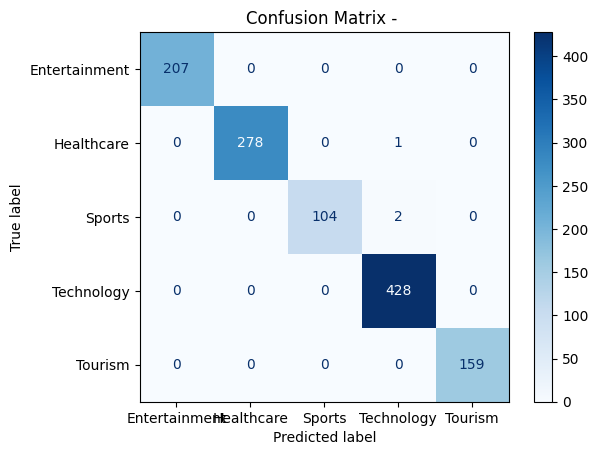

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
y_pred_1 = model_1.predict(X_test_tfidf).argmax(axis=1)
y_true_1 = y_test.argmax(axis=1)
cm_1 = confusion_matrix(y_true_1, y_pred_1)
#conf_matrices[name] = cm_1
accuracy = accuracy_score(y_true_1, y_pred_1)
print(f"Accuracy: {accuracy:.4f}")
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_1, display_labels=domain_columns)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - ")
plt.show()
history_results['RNN'].history['test_accuracy']=accuracy

# BIRNN

In [ ]:

# 5. Compile and Train
optimizer = AdamW(learning_rate=0.0001)
model_2.compile(optimizer=optimizer, loss=focal_loss(alpha=0.25, gamma=2.0), metrics=["accuracy"])


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Get the number of training examples AFTER TF-IDF and reshaping
num_train_examples = X_train_tfidf.shape[0]
# Adjust y_train to match the number of training examples
y_train_subset = y_train[:num_train_examples]


history_results['BIRNN']= model_2.fit(X_train_tfidf, y_train_subset, epochs=5, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 62ms/step - accuracy: 0.4746 - loss: 0.2263 - val_accuracy: 0.8318 - val_loss: 0.1133
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.8882 - loss: 0.0892 - val_accuracy: 0.9898 - val_loss: 0.0229
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.9924 - loss: 0.0201 - val_accuracy: 1.0000 - val_loss: 0.0057
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 1.0000 - val_loss: 0.0013
Restoring model weights from the end of the best epoch: 5.


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step
Accuracy: 0.9992


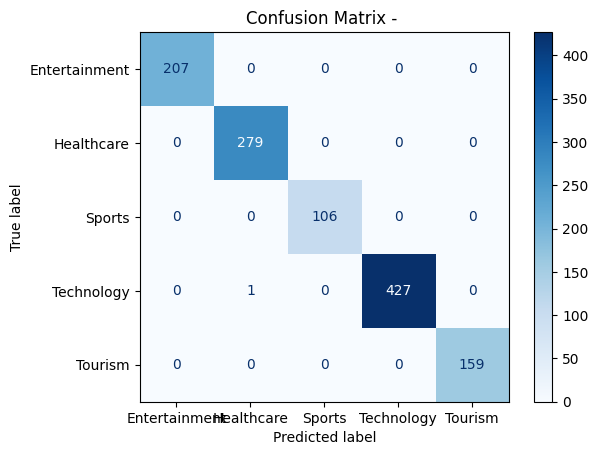

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
y_pred_2 = model_2.predict(X_test_tfidf).argmax(axis=1)
y_true_2 = y_test.argmax(axis=1)
cm_2 = confusion_matrix(y_true_2, y_pred_2)
#conf_matrices[name] = cm_1
accuracy = accuracy_score(y_true_2, y_pred_2)
print(f"Accuracy: {accuracy:.4f}")
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_2, display_labels=domain_columns)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - ")
plt.show()
history_results['BIRNN'].history['test_accuracy']=accuracy

# LSTM

In [ ]:

# 5. Compile and Train
optimizer = AdamW(learning_rate=0.0001)
model_3.compile(optimizer=optimizer, loss=focal_loss(alpha=0.25, gamma=2.0), metrics=["accuracy"])


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Get the number of training examples AFTER TF-IDF and reshaping
num_train_examples = X_train_tfidf.shape[0]
# Adjust y_train to match the number of training examples
y_train_subset = y_train[:num_train_examples]


history_results['LSTM'] = model_3.fit(X_train_tfidf, y_train_subset, epochs=5, batch_size=32, validation_data=(X_val_tfidf, y_val),callbacks=[early_stopping],  class_weight=class_weight_dict)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 23s 95ms/step - accuracy: 0.3582 - loss: 0.2571 - val_accuracy: 0.3605 - val_loss: 0.2534
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.3814 - loss: 0.2526 - val_accuracy: 0.3707 - val_loss: 0.2417
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - accuracy: 0.4173 - loss: 0.2386 - val_accuracy: 0.4790 - val_loss: 0.2066
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - accuracy: 0.5201 - loss: 0.1944 - val_accuracy: 0.5656 - val_loss: 0.1516
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 57ms/step - accuracy: 0.6349 - loss: 0.1295 - val_accuracy: 0.6522 - val_loss: 0.1031
Restoring model weights from the end of the best epoch: 5.


37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step
Accuracy: 0.6794


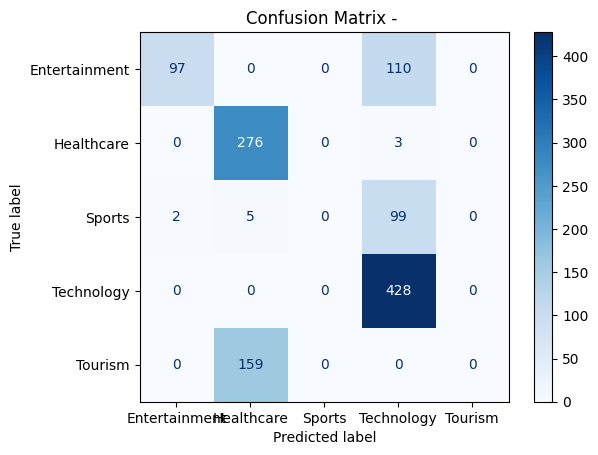

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
y_pred_3 = model_3.predict(X_test_tfidf).argmax(axis=1)
y_true_3 = y_test.argmax(axis=1)
cm_3 = confusion_matrix(y_true_3, y_pred_3)
#conf_matrices[name] = cm_1
accuracy = accuracy_score(y_true_3, y_pred_3)
print(f"Accuracy: {accuracy:.4f}")
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_3, display_labels=domain_columns)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - ")
plt.show()
history_results['LSTM'].history['test_accuracy']=accuracy

# BILSTM

In [ ]:

# 5. Compile and Train
optimizer = AdamW(learning_rate=0.0001)
model_4.compile(optimizer=optimizer, loss=focal_loss(alpha=0.25, gamma=2.0), metrics=["accuracy"])


class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weight_dict = dict(enumerate(class_weights))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Get the number of training examples AFTER TF-IDF and reshaping
num_train_examples = X_train_tfidf.shape[0]
# Adjust y_train to match the number of training examples
y_train_subset = y_train[:num_train_examples]


history_results['BILSTM']= model_4.fit(X_train_tfidf, y_train_subset, epochs=5, batch_size=32, validation_data=(X_val_tfidf, y_val), callbacks=[early_stopping], class_weight=class_weight_dict)

Epoch 1/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 49s 308ms/step - accuracy: 0.3486 - loss: 0.2576 - val_accuracy: 0.3605 - val_loss: 0.2416
Epoch 2/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 248ms/step - accuracy: 0.4155 - loss: 0.2277 - val_accuracy: 0.5490 - val_loss: 0.1677
Epoch 3/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 250ms/step - accuracy: 0.6236 - loss: 0.1471 - val_accuracy: 0.8828 - val_loss: 0.0821
Epoch 4/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 16s 256ms/step - accuracy: 0.8849 - loss: 0.0660 - val_accuracy: 0.9720 - val_loss: 0.0299
Epoch 5/5
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 246ms/step - accuracy: 0.9727 - loss: 0.0267 - val_accuracy: 0.9987 - val_loss: 0.0113
Restoring model weights from the end of the best epoch: 5.


37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step
Accuracy: 0.9992


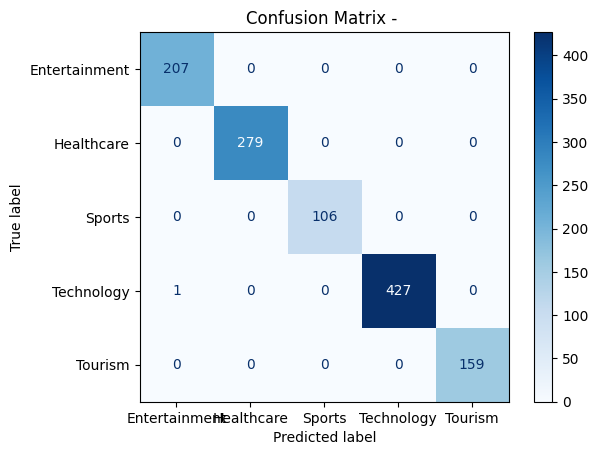

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
y_pred_4 = model_4.predict(X_test_tfidf).argmax(axis=1)
y_true_4 = y_test.argmax(axis=1)
cm_4 = confusion_matrix(y_true_4, y_pred_4)
#conf_matrices[name] = cm_1
accuracy = accuracy_score(y_true_4, y_pred_4)
print(f"Accuracy: {accuracy:.4f}")
# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm_4, display_labels=domain_columns)
disp.plot(cmap='Blues', values_format='d')
plt.title(f"Confusion Matrix - ")
plt.show()
history_results['BILSTM'].history['test_accuracy']=accuracy

# COMPARISON

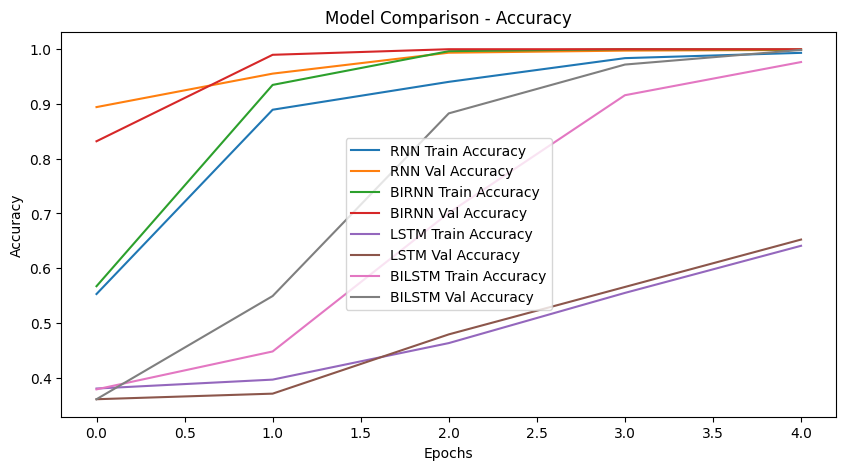

In [ ]:
# Plot Accuracy
plt.figure(figsize=(10, 5))
for name, history in history_results.items():
    plt.plot(history.history['accuracy'], label=f"{name} Train Accuracy")
    plt.plot(history.history['val_accuracy'], label=f"{name} Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Comparison - Accuracy")
plt.legend()
plt.show()


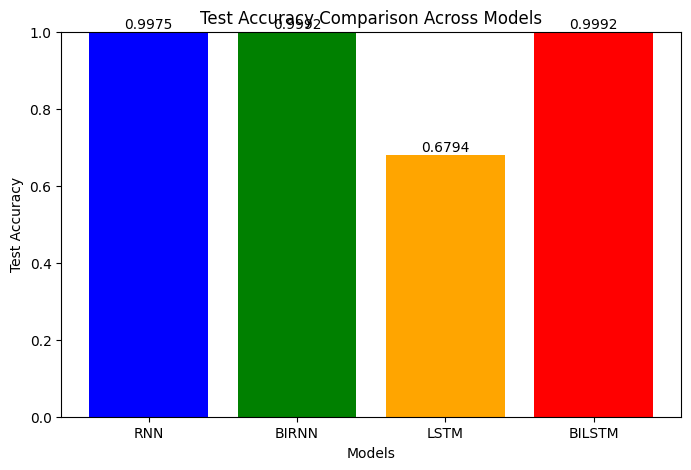

In [ ]:
# Extract test accuracies from history_results
test_accuracies = {
    name: history.history.get('test_accuracy', None)  # Use `.history` attribute
    for name, history in history_results.items()
    if 'test_accuracy' in history.history
}

# Plot test accuracies
plt.figure(figsize=(8, 5))
plt.bar(test_accuracies.keys(), test_accuracies.values(), color=['blue', 'green', 'orange', 'red'])
plt.xlabel("Models")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy Comparison Across Models")
plt.ylim(0, 1)  # Test accuracy values are between 0 and 1
for i, v in enumerate(test_accuracies.values()):
    if v is not None:  # Avoid errors if test_accuracy is None
        plt.text(i, v + 0.01, f"{v:.4f}", ha='center')  # Display accuracy values above bars
plt.show()
